# Jigsaw test

This is a prototype for using JIGSAW for creating a SCHISM compatible grid.

In [ ]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely import geometry, ops
import geopandas as gp
import xarray as xr
import pyPoseidon.dem as pdem
import pyPoseidon.meteo as pmeteo
from pyPoseidon.utils import data,point
import glob
import os
import shutil

In [2]:
import subprocess
from shutil import copyfile

In [3]:
%matplotlib inline

## create input .msh

In [4]:
#Define the coastline shapefile
shapefile = '/Users/brey/DATA/COASTLINES/naturalearth/coastline/ne_%sm_coastline' % \
                    {'l':110, 'i':50, 'h':10}['i']

In [5]:
#read it into a DataFrame
shp = gp.GeoDataFrame.from_file(shapefile+'.shp')


In [6]:
shp['length']=shp['geometry'][:].length # optional

In [7]:
shp = shp.sort_values(by='length', ascending=0) #optional
shp = shp.reset_index(drop=True)

In [8]:
shp.head()

,scalerank,featurecla,geometry,length
0,0,Coastline,"(LINESTRING (54.71005859375001 40.89111328125,...",1673.694717
1,0,Coastline,"LINESTRING (-136.44375 68.89511718750001, -136...",1163.804728
2,0,Coastline,"LINESTRING (-180 -84.3515625, -178.38950195312...",808.858432
3,0,Coastline,"LINESTRING (-51.21015624999998 68.419921875, -...",395.749437
4,0,Coastline,"LINESTRING (-68.72119140625 81.26123046875, -6...",220.875888


In [9]:
#put all Lines in a list
ls=[]
for i in range(shp.shape[0]):
    il = shp.loc[i,'geometry']
    try:
        print len(il)
        for k in range(len(list(il.geoms))):
               ls.append(list(il.geoms)[k])
    except:
        ls.append(il)

2


In [10]:
sall = geometry.MultiLineString(ls) #join them into a Multiline

In [11]:
c = ops.linemerge(sall) #merge parts if possible

In [12]:
len(c)

1422

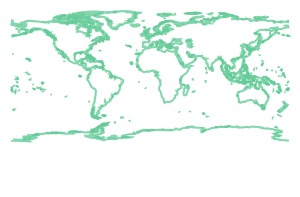

In [13]:
c #visualize

In [14]:
# lat/lon window case1
minlon = 160. 
maxlon = 177.
minlat = -49.
maxlat = -33.

In [15]:
# lat/lon window case2
minlon = -79. 
maxlon =  -76.
minlat = 17.
maxlat = 19.

In [16]:
#create a polygon of the grid
grp=geometry.Polygon([(minlon,minlat),(minlon,maxlat),(maxlon,maxlat),(maxlon,minlat)])

In [17]:
cl=[] #initialize
#add Polygons if they intersect with the grid
for i in range(len(c)):
    z = geometry.Polygon(c[i])
    if z.intersects(grp): 
            cl.append(c[i])

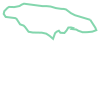

In [18]:
cll = geometry.MultiLineString(cl) #join them into a Multiline

cg = ops.linemerge(cll) #merge parts if possible

cg

In [19]:
#get all lines in a pandas DataFrame
if cg.type == 'LineString':
        lon=[]
        lat=[]
        for x,y in cg.coords[:]:
            lon.append(x)
            lat.append(y)
        dic= {'line0':{'lon':lon,'lat':lat}}
elif cg.type == 'MultiLineString' :
    dic={}
    for l in range(len(cg)):
        lon=[]
        lat=[]
        for x,y in cg[l].coords[:]:
            lon.append(x)
            lat.append(y)
        dic.update({'line{}'.format(l):{'lon':lon,'lat':lat}})

In [20]:
dict_of_df = {k: pd.DataFrame(v) for k,v in dic.items()}
df = pd.concat(dict_of_df, axis=0)
df.head()

lat        lon
line0 0  18.151855 -76.349854
      1  18.257178 -76.700732
      2  18.304297 -76.793262
      3  18.390430 -76.908203
      4  18.401855 -76.959375

In [21]:
df.shape

(48, 2)

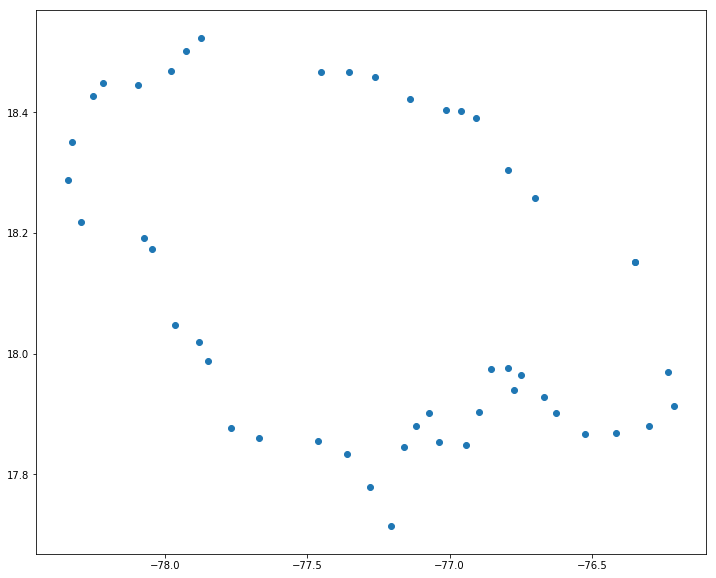

In [22]:
#plot xy points
plt.figure(figsize=(12,10))
plt.scatter(df.loc[:,'lon'],df.loc[:,'lat'])

## GEO.msh file 

In [23]:
box = pd.DataFrame([[minlon,minlat],[maxlon,minlat],[maxlon,maxlat],[minlon,maxlat]],columns=['lon','lat'])

In [24]:
box

,lon,lat
0,-79.0,17.0
1,-76.0,17.0
2,-76.0,19.0
3,-79.0,19.0


In [25]:
df = box.append(pd.DataFrame({'lon':lon,'lat':lat}))

In [26]:
df['z']=0

In [27]:
df.reset_index(inplace=True)

In [28]:
df.head()

,index,lat,lon,z
0,0,17.000000,-79.000000,0
1,1,17.000000,-76.000000,0
2,2,19.000000,-76.000000,0
3,3,19.000000,-79.000000,0
4,0,18.151855,-76.349854,0


In [29]:
df.tail()

,index,lat,lon,z
47,43,17.868213,-76.415527,0
48,44,17.879834,-76.301465,0
49,45,17.913525,-76.210791,0
50,46,17.970312,-76.232764,0
51,47,18.151855,-76.349854,0


In [30]:
df.shape

(52, 4)

In [31]:
msh='/Users/brey/Downloads/JIGSAW/geo/Jamaica-GEOM.msh'

In [32]:
# write header
with open(msh,'w') as f:
    f.write('MSHID=2;EUCLIDEAN-MESH\n')
    f.write('NDIMS=2\n')
    f.write('POINT={}\n'.format(df.shape[0]))    

In [33]:
with open(msh, 'a') as f:
    df.to_csv(f, index=False, header=0, columns=['lon','lat','z'],sep=';')

In [34]:
box = pd.DataFrame([[0,1,0],[1,2,0],[2,3,0],[3,0,0]])

In [35]:
# get edges
edges = box.append(pd.DataFrame([[i,i + 1,0] for i in range(4, len(lon)+4)]))

In [36]:
edges.head()

,0,1,2
0,0,1,0
1,1,2,0
2,2,3,0
3,3,0,0
0,4,5,0


In [37]:
edges.tail()

,0,1,2
43,47,48,0
44,48,49,0
45,49,50,0
46,50,51,0
47,51,52,0


In [38]:
edges.iloc[-1][1]=4

In [39]:
# write header
with open(msh,'a') as f:
    f.write('EDGE2={}\n'.format(edges.shape[0]))

In [40]:
with open(msh, 'a') as f:
    edges.to_csv(f, index=False, header=0, sep=';')

## hfun file

In [41]:
xpos = np.linspace(minlon,maxlon,128)

In [42]:
ypos = np.linspace(minlat,maxlat,128)

In [43]:
XPOS,YPOS = np.meshgrid(xpos,ypos)

In [44]:
mlon = np.mean([minlon,maxlon])

In [45]:
mlat = np.mean([minlat,maxlat])

In [46]:
hfun =-.3*np.exp(-.1*(XPOS-mlon)**2 -.1*(YPOS-mlat)**2) + .4 
hfun

array([[0.18324179, 0.18171244, 0.18019682, ..., 0.18019682, 0.18171244,
        0.18324179],
       [0.18256341, 0.18102926, 0.1795089 , ..., 0.1795089 , 0.18102926,
        0.18256341],
       [0.18189372, 0.18035485, 0.17882981, ..., 0.17882981, 0.18035485,
        0.18189372],
       ...,
       [0.18189372, 0.18035485, 0.17882981, ..., 0.17882981, 0.18035485,
        0.18189372],
       [0.18256341, 0.18102926, 0.1795089 , ..., 0.1795089 , 0.18102926,
        0.18256341],
       [0.18324179, 0.18171244, 0.18019682, ..., 0.18019682, 0.18171244,
        0.18324179]])

In [47]:
hf = pd.DataFrame({'xpos':xpos,'ypos':ypos})

In [48]:
hf.head()

,xpos,ypos
0,-79.000000,17.000000
1,-78.976378,17.015748
2,-78.952756,17.031496
3,-78.929134,17.047244
4,-78.905512,17.062992


In [49]:
ffun='/Users/brey/Downloads/JIGSAW/out/Jamaica-HFUN.msh'

In [50]:
# write header
with open(ffun,'w') as f:
    # BOX-HFUN.msh; created by JIGSAW's OCTAVE interface
    f.write('MSHID=3;EUCLIDEAN-GRID\n')
    f.write('NDIMS=2\n')
    f.write('COORD=1;128\n')

In [51]:
with open(ffun, 'a') as f:
    hf['xpos'].to_csv(f, index=False, header=0)

In [52]:
with open(ffun, 'a') as f:
    f.write('COORD=2;128\n')

In [53]:
with open(ffun, 'a') as f:
    hf['ypos'].to_csv(f, index=False, header=0)

In [54]:
with open(ffun, 'a') as f:
    f.write('VALUE=16384;1\n')

In [55]:
with open(ffun, 'a') as f:
    for i in range(hfun.size):
        f.write('{}\n'.format(hfun.flatten()[i]))

## Execute jigsaw

In [56]:
! /Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/bin/MAC-64/jigsaw64r /Users/brey/Downloads/JIGSAW/Jamaica.jig

 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation package.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.5

  Reading CFG. file...

  CFG. data summary...

  GEOM_FILE = /Users/brey/Downloads/JIGSAW/geo/Jamaica-GEOM.msh 
  MESH_FILE = /Users/brey/Downloads/JIGSAW/out/Jamaica.msh 
  HFUN_FILE = /Users/brey/Downloads/JIGSAW/out/Jamaica-HFUN.msh 

  GEOM_SEED = 8 
  GEOM_PHI1 = 6.00e+01 
  GEOM_PHI2 = 6.00e+01 
  GEOM_ETA1 = 4.50e+01 
  GEOM_ETA2 = 4.50e+01 
  GEOM_FEAT = F

## read output .msh

In [57]:
msh='/Users/brey/Downloads/JIGSAW/out/Jamaica.msh'

In [58]:
#extract number of elements, number of nodes
point,nn=pd.read_csv(msh,header=2,skiprows=1,nrows=0,delimiter='=')

In [59]:
nn

'407'

In [60]:
nn=int(nn)

In [61]:
#read lon,lat,depth for all nodes
xy=pd.read_csv(msh,skiprows=4,header=None,delimiter=';',engine='python',nrows=nn,names=['x','y','z'])

In [62]:
xy.shape

(407, 3)

In [63]:
xy.head()

,x,y,z
0,-76.000000,19.000000,0
1,-79.000000,17.000000,0
2,-76.000000,17.000000,0
3,-79.000000,19.000000,0
4,-77.463867,17.856055,0


In [64]:
xy.tail()

,x,y,z
402,-78.074886,18.012618,0
403,-77.135331,17.696475,0
404,-77.916107,17.780367,0
405,-78.031492,17.922298,0
406,-77.032687,17.504780,0


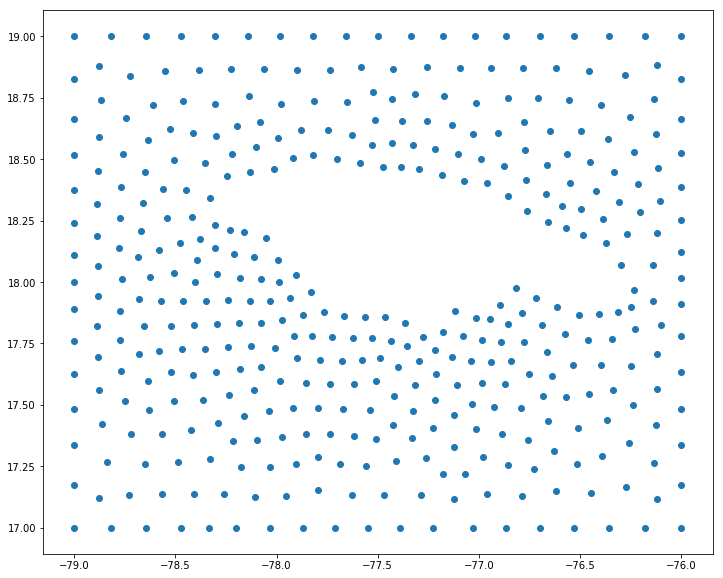

In [65]:
#plot xy points
plt.figure(figsize=(12,10))
plt.scatter(xy.x, xy.y)

In [66]:
power,pn=pd.read_csv(msh,header=4,skiprows=nn,nrows=0,delimiter='=')

In [67]:
pn,s = pn.split(';')

In [68]:
pn = int(pn)

In [69]:
pr=pd.read_csv(msh,skiprows=nn+5,header=None,delimiter=';',engine='python',nrows=pn,names=['a'])

### EDGES

In [70]:
edge2,ne=pd.read_csv(msh,header=4,skiprows=nn+pn+1,nrows=0,delimiter='=')

In [71]:
ne = int(ne)

In [72]:
ne

112

In [73]:
e2=pd.read_csv(msh,skiprows=nn+pn+6,header=None,delimiter=';',engine='python',nrows=ne,names=['a','b','c'])

In [74]:
e2.head()

,a,b,c
0,67,91,0
1,49,72,0
2,78,97,0
3,9,42,0
4,39,58,0


In [75]:
e2.tail()

,a,b,c
107,29,47,0
108,32,43,0
109,60,102,0
110,30,44,0
111,77,98,0


In [76]:
#get edge lon/lat
elon=[]
elat=[]
for index, row in e2.loc[:,['a','b']].iterrows():
    i, j = row['a'], row['b']
    elon.append(xy.x[i])
    elat.append(xy.y[i])
    elon.append(xy.x[j])
    elat.append(xy.y[j])


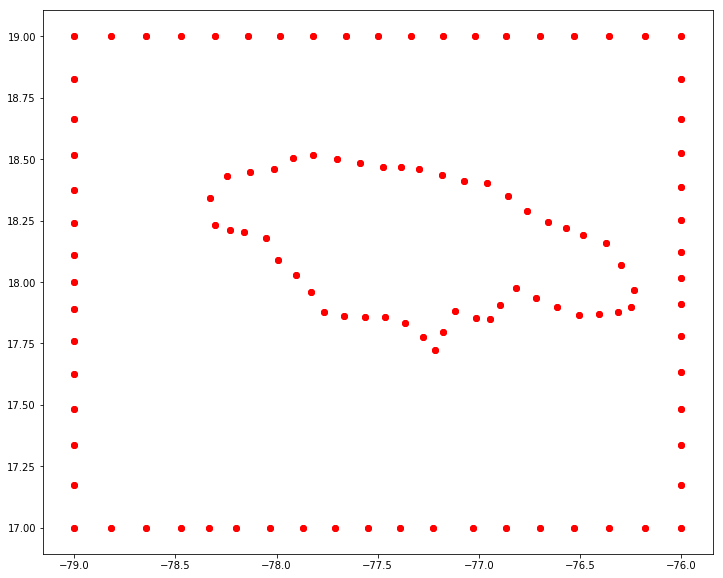

In [77]:
#plot e2
plt.figure(figsize=(12,10))
plt.scatter(elon,elat,c='r')


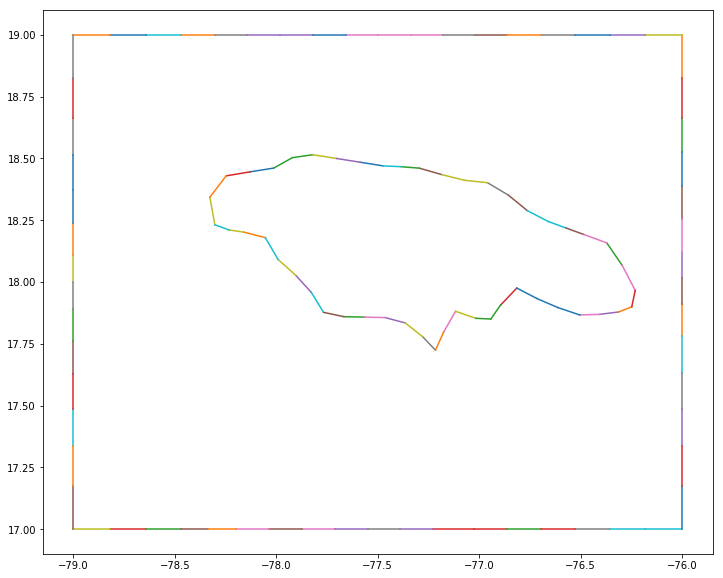

In [78]:
#plot e2
plt.figure(figsize=(12,10))
for index, row in e2.loc[:,['a','b']].iterrows():
    i, j = row['a'], row['b']
    p1 = (xy.x[i],xy.x[j])
    p2 = (xy.y[i],xy.y[j])
    plt.plot(p1,p2)

In [79]:
sh = zip(elon,elat)

In [80]:
csh = [sh[i:i + 2] for i in xrange(0, len(sh), 2)]

In [81]:
mlist=[]
for i in range(len(csh)):
     mlist.append(geometry.LineString(csh[i]))

In [82]:
print mlist[4]

LINESTRING (-77.81992932918791 19, -77.98214964387654 19)


In [83]:
sall = geometry.MultiLineString(mlist)

In [84]:
c = ops.linemerge(sall)

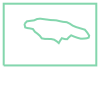

In [85]:
c

In [86]:
len(c)

2

### TRIANGLES

In [87]:
edge3,n3e=pd.read_csv(msh,header=4,skiprows=nn+pn+ne+2,nrows=0,delimiter='=')

In [88]:
n3e

'702'

In [89]:
n3e = int(n3e)

In [90]:
e3=pd.read_csv(msh,skiprows=nn+pn+ne+7,header=None,delimiter=';',engine='python',nrows=n3e,names=['a','b','c','q'])

In [91]:
e3.head()

,a,b,c,q
0,297,162,328,0
1,217,219,354,0
2,292,304,389,0
3,147,41,173,0
4,137,183,394,0


In [92]:
e3.tail()

,a,b,c,q
697,282,281,314,0
698,91,104,134,0
699,116,403,224,0
700,116,65,403,0
701,65,108,403,0


In [93]:
e3['q']=3

In [94]:
e3.head()

,a,b,c,q
0,297,162,328,3
1,217,219,354,3
2,292,304,389,3
3,147,41,173,3
4,137,183,394,3


In [95]:
tri3 = e3.loc[:,['a','b','c']].values

In [96]:
tri3

array([[297, 162, 328],
       [217, 219, 354],
       [292, 304, 389],
       ...,
       [116, 403, 224],
       [116,  65, 403],
       [ 65, 108, 403]])

In [97]:
xy.x.iloc[-1],xy.y.iloc[-1]

(-77.03268690425891, 17.504779721941823)

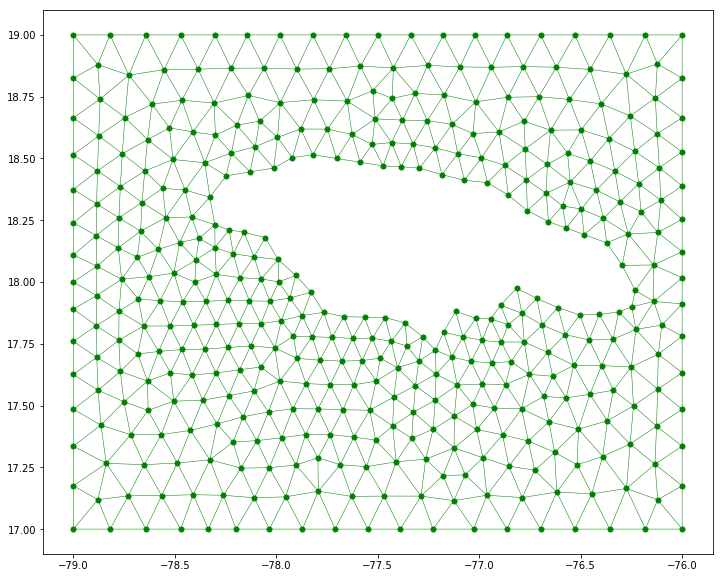

In [98]:
#plot e3
plt.figure(figsize=(12,10))
plt.triplot(xy.x, xy.y, tri3, 'go-', lw=.5, markersize=5 )
plt.show()

### Get depth

In [ ]:
# Get Bathymetry
b = pdem.erdap(**{'minlon' : -79., 'maxlon' :  -76., 'minlat' : 17., 'maxlat' : 19., 'grid_x' : xy.x, 'grid_y' : xy.y})


extracting dem from http://coastwatch.pfeg.noaa.gov/erddap/griddap/srtm15plus


In [ ]:
b.Dataset

In [ ]:
b.Dataset.ival.max(), b.Dataset.ival.min()

In [106]:
b.Dataset.ival

<xarray.DataArray 'ival' (k: 407)>
array([-2894.,  -990., -1823., ...,  -454.,  -284.,  -901.], dtype=float32)
Dimensions without coordinates: k

In [107]:
pp = np.argwhere(b.Dataset.ival.values > 0)

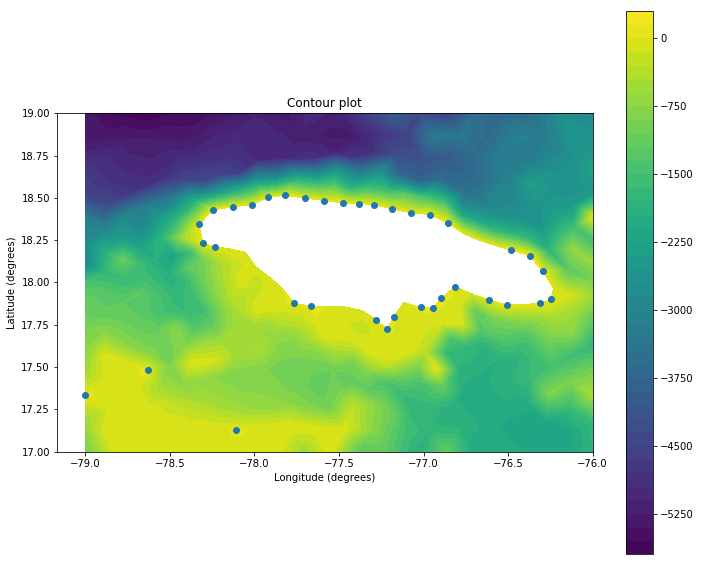

In [110]:
# plot bathymetry
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal')
plt.tricontourf(xy.x, xy.y, tri3, b.Dataset.ival, 50, )
plt.colorbar()
plt.scatter(b.Dataset.ilons.values[pp], b.Dataset.ilats.values[pp])
plt.title('Contour plot')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

In [111]:
b.Dataset.ival[b.Dataset.ival>0] = 0. # fix???

# Save necessary input files for Schism

In [112]:
folder = '/Users/brey/SCHISM/test_grid/'

### hgrid.gr3

In [113]:
grid = xy.copy()
grid = grid.loc[:,:].astype(float)

In [115]:
grid.loc[:,'z'] = - b.Dataset.ival

In [116]:
grid.index = grid.index + 1 # change index start

In [117]:
grid.head()

,x,y,z
1,-76.000000,19.000000,2894.0
2,-79.000000,17.000000,990.0
3,-76.000000,17.000000,1823.0
4,-79.000000,19.000000,5332.0
5,-77.463867,17.856055,90.0


In [118]:
grid.tail()

,x,y,z
403,-78.074886,18.012618,22.0
404,-77.135331,17.696475,7.0
405,-77.916107,17.780367,454.0
406,-78.031492,17.922298,284.0
407,-77.032687,17.504780,901.0


In [119]:
g3file=folder+'hgrid.gr3'

In [120]:
with open(g3file,'w') as f:
    f.write('\t uniform.gr3\n')
    f.write('\t {} {}\n'.format(n3e,nn))
    

In [121]:
grid.to_csv(g3file,index=True, sep='\t', header=None,mode='a', float_format='%.10f', columns=['x','y','z'])

In [122]:
# Add one to reset the node counter
c3 = e3.copy()
c3.loc[:,['a']]=c3.loc[:,['a']]+1
c3.loc[:,['b']]=c3.loc[:,['b']]+1
c3.loc[:,['c']]=c3.loc[:,['c']]+1
c3.index = c3.index + 1 # adjust index start
c3.head()

,a,b,c,q
1,298,163,329,3
2,218,220,355,3
3,293,305,390,3
4,148,42,174,3
5,138,184,395,3


In [123]:
c3.to_csv(g3file,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

In [124]:
# identify the node numbers of boundaries
idx=[]
for i in range(len(c[0].coords)):
    bx,by = c[0].coords[i]
    idx.append(grid.loc[(grid['x'] == bx) & (grid['y'] == by)].index.values)

In [125]:
fidx = [item for sublist in idx for item in sublist]
fidx = fidx[:-1]

In [126]:
with open(g3file, 'a') as f:
    f.write('{} = Number of open boundaries\n'.format(1))
    f.write('{} = Total number of open boundary nodes\n'.format(len(fidx)))
    f.write('{} = Number of nodes for open boundary 1\n'.format(len(fidx)))
    for item in fidx:
        f.write("%s\n" % item)

In [127]:
# identify the node numbers of boundaries
idx=[]
for i in range(len(c[1].coords)):
    bx,by = c[1].coords[i]
    idx.append(grid.loc[(grid['x'] == bx) & (grid['y'] == by)].index.values)

In [128]:
fidx = [item for sublist in idx for item in sublist]
fidx = fidx[:-1]

In [129]:
with open(g3file, 'a') as f:
    f.write('{} = Number of land boundaries\n'.format(1))
    f.write('{} = Total number of land boundary nodes\n'.format(len(fidx)))
    f.write('{} 1 = Number of nodes for land boundary 1\n'.format(len(fidx)))
    for item in fidx:
        f.write("%s\n" % item)

### hgrid.ll

In [130]:
llfile=folder+'hgrid.ll'

In [131]:
copyfile(g3file, llfile)

### manning.gr3

In [132]:
manfile=folder+'manning.gr3'

In [133]:
with open(manfile,'w') as f:
    f.write('\t 0 \n')
    f.write('\t {} {}\n'.format(n3e,nn))

In [134]:
grid['man']=.12
grid.head()

,x,y,z,man
1,-76.000000,19.000000,2894.0,0.12
2,-79.000000,17.000000,990.0,0.12
3,-76.000000,17.000000,1823.0,0.12
4,-79.000000,19.000000,5332.0,0.12
5,-77.463867,17.856055,90.0,0.12


In [135]:
grid.to_csv(manfile,index=True, sep='\t', header=None,mode='a', float_format='%.10f',columns=['x','y','man'] )

In [136]:
c3.to_csv(manfile,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

### windrot_geo2proj.gr3

In [137]:
windfile=folder+'windrot_geo2proj.gr3'

In [138]:
with open(windfile,'w') as f:
    f.write('\t 0 \n')
    f.write('\t {} {}\n'.format(n3e,nn))

In [139]:
grid['windrot']=0.000001
grid.head()

,x,y,z,man,windrot
1,-76.000000,19.000000,2894.0,0.12,0.000001
2,-79.000000,17.000000,990.0,0.12,0.000001
3,-76.000000,17.000000,1823.0,0.12,0.000001
4,-79.000000,19.000000,5332.0,0.12,0.000001
5,-77.463867,17.856055,90.0,0.12,0.000001


In [140]:
grid.to_csv(windfile,index=True, sep='\t', header=None,mode='a', float_format='%.10f',columns=['x','y','windrot'] )

In [141]:
c3.to_csv(windfile,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

## Get uvp forcing

In [142]:
meteo = pmeteo.gfs_erdap(**{'minlon':minlon-.1, # lat/lon window
     'maxlon':maxlon+.1,
     'minlat':minlat-.1,
     'maxlat':maxlat+.1,
     'start_date':'2013-10-28',
     'end_date':'2013-10-29',
    })


extracting meteo from https://bluehub.jrc.ec.europa.eu/erddap/griddap/NCEP_Global_Best.html

meteo done


In [143]:
xx, yy = np.meshgrid(meteo.uvp.longitude.data, meteo.uvp.latitude.data)

In [144]:
zero = np.zeros(meteo.uvp.msl.data.shape)

In [145]:
tlist = (meteo.uvp.time.data - meteo.uvp.time.data[0]).astype('timedelta64[s]')/3600.

In [146]:
tlist = tlist.astype(float)/24.

In [147]:
udate = pd.to_datetime(meteo.uvp.time[0].data).strftime('%Y-%m-%d')

In [148]:
bdate = pd.to_datetime(meteo.uvp.time[0].data).strftime('%Y %m %d %H').split(' ')

In [149]:
bdate = [int(q) for q in bdate]

In [150]:
sout= xr.Dataset({'prmsl':(['time', 'nx_grid', 'ny_grid'], meteo.uvp.msl.data),
                  'uwind':(['time','nx_grid','ny_grid'], meteo.uvp.u10.data),
                  'vwind':(['time','nx_grid','ny_grid'], meteo.uvp.v10.data),
                  'spfh':(['time','nx_grid','ny_grid'], zero),
                  'stmp':(['time','nx_grid','ny_grid'], zero),
                  'lon':(['nx_grid','ny_grid'], xx),
                  'lat':(['nx_grid','ny_grid'], yy)},
             coords={'time':tlist})

In [151]:
sout.attrs={'description' : 'Schism forsing',
    'history' :'JRC Ispra European Commission',
    'source' : 'netCDF4 python module'}

In [152]:
sout.time.attrs={   'long_name':      'Time',
                    'standard_name':  'time',
                    'base_date':      bdate,
                    'units':          udate}

In [153]:
sout.lon.attrs={'units': 'degrees_east',
               'long_name': 'Longitude',
               'standard_name':'longitude'}

In [154]:
sout.lat.attrs={'units': 'degrees_north',
               'long_name': 'Latitude',
               'standard_name':'latitude'}

In [155]:
sout.prmsl.attrs={'units': 'Pa',
               'long_name': 'Pressure reduced to MSL',
               'standard_name':'air_pressure_at_sea_level'}

In [156]:
sout.uwind.attrs={'units': 'm/s',
               'long_name': 'Surface Eastward Air Velocity',
               'standard_name':'eastward_wind'}

In [157]:
sout.vwind.attrs={'units': 'm/s',
               'long_name': 'Surface Northward Air Velocity',
               'standard_name':'northward_wind'}

In [158]:
sout.spfh.attrs={'units': '1',
               'long_name': 'Surface Specific Humidity (2m AGL)',
               'standard_name':'specific_humidity'}

In [159]:
sout.stmp.attrs={'units': 'degrees',
               'long_name': 'Surface Temperature',
               'standard_name':'surface temperature'}

In [160]:
if not os.path.exists(folder + 'sflux'):
            os.makedirs(folder + 'sflux')

In [161]:
sout.to_netcdf(folder+'sflux/sflux_air_1.001.nc')

### sflux_inputs.txt

In [162]:
with open(folder+'sflux/sflux_inputs.txt', 'w') as f:
    f.write('&sflux_inputs\n')
    f.write('/ \n\n')

### param.in

In [163]:
sim = pd.to_datetime(meteo.uvp.time[0].values)
sim

Timestamp('2013-10-28 00:00:00')

In [165]:
dic = {
  'PH': 1,
  'airt': 0,
  'bage_elem':0,
  'bdrc': 0,
  'bfric': -1,
  'bpgr_side': 0,
  'bthk_elem': 0,
  'btrack_nudge': 1.013e-3,
  'conc': 0,
  'consv_check': 0,
  'courant_weno': 0.5,
  'cpp_lat': 36,
  'cpp_lon': -6,
  'dahv': 0,
  'depth_zsigma': 100.,
  'dramp': 1.,
  'dramp_ss': 2,
  'drampbc': 1.,
  'dt': 400,
  'dtb_max': 30.,
  'dtb_min': 30.,
  'eco_class': 27,
  'elev': 1,
  'eps1_tvd_imp': 1.e-4,
  'eps2_tvd_imp': 1.e-14,
  'epsilon1': 1.e-3,
  'epsilon2': 1.e-10,
  'epsilon3': 1.e-25,
  'evap': 0,
  'flag_fib': 1,
  'fllu': 0,
  'flsu': 0,
  'flux': 0,
  'gen_wsett': 1.e-4,
  'h0': 0.5,
  'h_tvd': 5.,
  'hmin_man': 1,
  'hmin_radstress': 0.,
  'hotout': 0,
  'hotout_write': 1440,
  'hvel': 1 ,
  'hvel_side': 0,
  'hvis_coef0': 0.025,
  'ibcc': 1,
  'ibcc_mean': 0,
  'ibtrack_test': 0,
  'ic_elev': 0,
  'icou_elfe_wwm': 0,
  'ics': 2,
  'ielad_weno': 0,
  'ieos_pres': 0,
  'ieos_type': 0,
  'if_source': 0,
  'iharind': 0,
  'ihconsv': 0,
  'ihdif': 0,
  'ihfskip': 36,
  'ihhat': 1,
  'ihorcon': 0,
  'ihot': 0,
  'ihydraulics': 0,
  'imm': 0,
  'indvel': 1,
  'inter_mom': 0,
  'inu_AGE': 0,
  'inu_COS': 0,
  'inu_ECO': 0,
  'inu_FIB': 0,
  'inu_GEN': 0,
  'inu_ICM': 0,
  'inu_SAL': 0,
  'inu_SED': 0,
  'inu_TEM': 0,
  'inu_elev': 0,
  'inu_uv': 0,
  'inunfl': 0,
  'inv_atm_bnd': 0,
  'iout_sta': 0,
  'ip_weno': 2,
  'ipre': 0,
  'irouse_test': 0,
  'isav': 0,
  'isconsv': 0,
  'ishapiro': 0,
  'itr_met': 1,
  'itransport': 0,
  'itur': 0,
  'iupwind_mom': 0,
  'iwbl': 0,
  'izonal5': 0,
  'kine': 0,
  'kr_co': 1,
  'mdc2': 10,
  'mixl': 0,
  'mrsh_elem': 0,
  'msc2': 10,
  'mxitn': 1500,
  'nadv': 1,
  'ncor': 1,
  'nquad': 2,
  'nramp': 1,
  'nramp_elev': 0,
  'nramp_ss': 1,
  'nrampbc': 0,
  'nspool': 9,
  'nspool_sta': 10,
  'nstep_ice': 1,
  'nstep_wwm': 1,
  'ntd_weno': 1,
  'nws': 2,
  'prcp': 0,
  'pres': 0,
  'prmsl_ref': 101325.,
  'qnon': 0,
  'radd': 0,
  'radu': 0,
  'rearth_eq': 6378206.4,
  'rearth_pole': 6378206.4,
  'rho0': ' 1000.d0',
  'rmaxvel': 50.,
  'rnday': 0.5,
  's1_mxnbt': 0.5,
  's2_mxnbt': 3.0,
  'salt': 1,
  'salt_elem': 0,
  'sav_cd': 1.13,
  'sed_class': 5,
  'shapiro': 0.5,
  'shum': 0,
  'shw': ' 4184.d0',
  'slr_rate': 120.,
  'slvr_output_spool': 50,
  'small_elad': 1.e-4,
  'srad': 0,
  'start_day': 28,
  'start_hour': 0,
  'start_month': 10,
  'start_year': 2013,
  'step_nu_tr': 86400.,
  'tdff': 0,
  'temp': 1,
  'temp_elem': 0,
  'thetai': 1,
  'tolerance': 1.e-12,
  'turb_met': ' KL ',
  'turb_stab': ' KC ',
  'utc_start': 0,
  'vdff': 0,
  'velmin_btrack':1.e-4,
  'vert': 1,
  'vert_elem': 0,
  'wave_force_side':0,
  'wind': 1,
  'wist': 0,
  'wtiminc': 400.,
  'xlsc0': 0.1,
  'z0st_elem': 0,
  'zcor': 1,
  'iwind_form': -1,
  'nrampwind': 1,
  'drampwind': 2,
  'iwindoff': 0,
  'dfv0': 0,
  'dfh0': 1.e-6,
  'ic_TEM': 1,
  'ic_SAL': 1
}

In [166]:
params = pd.DataFrame.from_dict(dic,orient = 'index')

In [167]:
#save
params.to_csv(folder + 'param.in', header=None, sep='=')

### bctides.in 

In [168]:
with open(folder + 'bctides.in', 'w') as f:
    f.write('Header\n')
    f.write('{} {}\n'.format(0, 40.)) #  ntip tip_dp
    f.write('{}\n'.format(0)) #nbfr
    f.write('{}\n'.format(1)) #number of open boundaries
    f.write('{} {} {} {} {}\n'.format(64,2,0,0,0)) # number of nodes on the open boundary segment j (corresponding to hgrid.gr3), B.C. flags for elevation, velocity, temperature, and salinity
    f.write('{}\n'.format(0)) # ethconst !constant elevation value for this segment

### vgrid.in

In [169]:
with open(folder + 'vgrid.in', 'w') as f:
    f.write('{}\n'.format(2)) #ivcor (1: LSC2; 2: SZ)
    f.write('{} {} {}\n'.format(2,1,1.e6)) #nvrt(=Nz); kz (# of Z-levels); hs (transition depth between S and Z)
    f.write('Z levels\n') # Z levels !Z-levels in the lower portion
    f.write('{} {}\n'.format(1,-1.e6)) #!level index, z-coordinates, z-coordinate of the last Z-level must match -hs 
    f.write('S levels\n') # S-levels below 
    f.write('{} {} {}\n'.format(40.,1.,1.e-4))  #constants used in S-transformation: h_c, theta_b, theta_f
    f.write('{} {}\n'.format(1,-1.)) #first S-level (sigma-coordinate must be -1)
    f.write('{} {}\n'.format(2,0.)) # levels index, sigma-coordinate, last sigma-coordinate must be 0


### launchSchism.sh

In [170]:
with open(folder + 'launchSchism.sh', 'w') as f:
    f.write('source activate mpi2\n')
    f.write('exec=/Users/brey/SCHISM/v5.6.1/src/schism.ex_VL\n')
    f.write('mkdir outputs\n')
    f.write('mpirun -N 4 $exec\n')

In [171]:
#make it executable
execf = folder+'launchSchism.sh'
mode = os.stat(execf).st_mode
mode |= (mode & 0o444) >> 2    # copy R bits to X
os.chmod(execf, mode)


## Execute Schism

In [172]:
# Make sure the outputs files is empty!!!
if os.path.exists(folder+'/outputs/'): 
    shutil.rmtree(folder+'/outputs/')

In [173]:
#Execute Schism
ex=subprocess.Popen(args=[folder+'./launchSchism.sh'], cwd=folder, shell=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE, bufsize=1)
for line in iter(ex.stderr.readline, b''):
    print line,
ex.stderr.close()
for line in iter(ex.stdout.readline, b''):
    print line,
ex.stdout.close()

### Data Visualization

In [174]:
out = data(rpath=folder,solver='schism')

Combining output


In [176]:
out.impl.Dataset

<xarray.Dataset>
Dimensions:                  (nMaxSCHISM_hgrid_face_nodes: 4, nSCHISM_hgrid_edge: 1109, nSCHISM_hgrid_face: 702, nSCHISM_hgrid_node: 407, nSCHISM_vgrid_layers: 2, one: 1, sigma: 2, time: 12, two: 2)
Coordinates:
  * sigma                    (sigma) float64 -1.0 0.0
  * time                     (time) datetime64[ns] 2013-10-28T01:00:00 ...
Dimensions without coordinates: nMaxSCHISM_hgrid_face_nodes, nSCHISM_hgrid_edge, nSCHISM_hgrid_face, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, one, two
Data variables:
    wetdry_elem              (time, nSCHISM_hgrid_face) float64 0.0 0.0 1.0 ...
    wind_speed               (time, nSCHISM_hgrid_node, two) float32 -8.126666 ...
    hvel                     (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, two) float32 -0.0009977188 ...
    elev                     (time, nSCHISM_hgrid_node) float32 0.0 0.0 0.0 ...
    vertical_velocity        (time, nSCHISM_hgrid_node, nSCHISM_vgrid_layers) float32 2.5050538e-05 ...
    temp          

In [177]:
h=out.impl.Dataset.elev.values

In [178]:
h.mean()

-0.00012314781

In [179]:
t = out.impl.Dataset.variables['time'][:]
t.values

array(['2013-10-28T01:00:00.000000000', '2013-10-28T02:00:00.000000000',
       '2013-10-28T03:00:00.000000000', '2013-10-28T04:00:00.000000000',
       '2013-10-28T05:00:00.000000000', '2013-10-28T06:00:00.000000000',
       '2013-10-28T07:00:00.000000000', '2013-10-28T08:00:00.000000000',
       '2013-10-28T09:00:00.000000000', '2013-10-28T10:00:00.000000000',
       '2013-10-28T11:00:00.000000000', '2013-10-28T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [180]:
from matplotlib import animation,rc

rc('animation',html='html5')
plt.rcParams["animation.html"] = "jshtml"

In [181]:
def anim(z,t,title=None):
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    ax.set_aspect('equal')
    v=np.linspace(z.min(),z.max(),10,endpoint=True)
    ims = []
    for i in range(len(t)):
        im = ax.tricontourf(grid.x, grid.y, tri3, z[i,:], v, vmin=z.min(), vmax=z.max())
#        im = ax.contourf(x,y,z[i,:,:],v,vmin=v1,vmax=v2,latlon=True)
        add_arts = im.collections
        text = 'time={}'.format(t[i])
        #te = ax.text(90, 90, text)
        an = ax.annotate(text, xy=(0.05, 1.05), xycoords='axes fraction')
        ims.append(add_arts + [an])
    ax.set_title(title)    
#cbar_ax = fig.add_axes([0.05, 0.05, 0.85, 0.05])    
    cbar = fig.colorbar(im,ticks=v,orientation='vertical', extend='both')#,fraction=0.046, pad=0.04)
#plt.colorbar()
    return animation.ArtistAnimation(fig, ims, interval=200, blit=False,repeat=False)

In [184]:
%%capture
v = anim(h,t.values,title='Storm Surge')

In [185]:
v

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
